In [1]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook
import pandas as pd
from keras.utils import np_utils
from sklearn.cluster import KMeans
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10

In [3]:
def GetHumanObservedFeatureData():
    humanSamePair = pd.read_csv('HumanObserved-Dataset/HumanObserved-Features-Data/same_pairs.csv') 
    humanDiffPair = pd.read_csv('HumanObserved-Dataset/HumanObserved-Features-Data/diffn_pairs.csv')
    #Reading human observed feature data csv 
    humanFeatureData = pd.read_csv('HumanObserved-Dataset/HumanObserved-Features-Data/HumanObserved-Features-Data.csv')
    #print(humanFeatureData.img_id)
    #print(humanSamePair.img_id_A, humanSamePair.img_id_B) 

    sameFeatureMerge=pd.merge(humanSamePair, humanFeatureData,  how='inner', left_on=['img_id_A'], right_on = ['img_id'], suffixes= ['_A','_A'])
    featureListSame=pd.merge(sameFeatureMerge, humanFeatureData, how='inner', left_on=['img_id_B'], right_on = ['img_id'], suffixes= ['_A','_B'])
    #print(featureListSame)

    diffFeatureMerge=pd.merge(humanDiffPair, humanFeatureData,  how='inner', left_on=['img_id_A'], right_on = ['img_id'], suffixes= ['_A','_A'])
    featureListDiff=pd.merge(diffFeatureMerge, humanFeatureData, how='inner', left_on=['img_id_B'], right_on = ['img_id'], suffixes= ['_A','_B'])
    return sameFeatureMerge, featureListSame, diffFeatureMerge, featureListDiff
    #print(featureListDiff.iloc[2])

In [4]:
sameFeatureMerge, featureListSame, diffFeatureMerge, featureListDiff = GetHumanObservedFeatureData()
#Getting the array vector of Target values from 'same_pairs.csv'.
def ProcessData(featureListSame,featureListDiff):
    t1 = []
    t1_target=[]
    t2_target=[]
    t1 =np.array(featureListSame.iloc[0:791,[2,5,6,7,8,9,10,11,12,13,16,17,18,19,20,21,22,23,24]].values)
    t2 = np.array(featureListDiff.iloc[0:791,[2,5,6,7,8,9,10,11,12,13,16,17,18,19,20,21,22,23,24]].values)
    t1=np.concatenate((t2,t1))
    np.random.shuffle(t1)
    #print(t1)
    return t1
t1 = ProcessData(featureListSame,featureListDiff)
print(t1.shape)

(1582, 19)


# Getting data for the dataset

In [5]:
#Getting the matrix of total data
def GenerateRawData(t1):    
    dataMatrix = [] 
    
    dataMatrix = np.transpose(t1)     
    print ("Data Matrix Shape.."+ str(dataMatrix.shape))
    return dataMatrix

def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    return t

def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(rawData.shape[0]*0.01*TrainingPercent))
    print("RawData"+str(rawData.shape))
    d2 = rawData[0:T_len,:]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2


#Generating the list of validation target values which is 10% of total length
#List of size 10% of the total length will be obtained.
def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(rawData.shape[0]*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount:V_End-1]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t

GenerateRawData(t1)

def GenerateValData(rawData, ValPercent, TrainingCount): 
    #ceil() returns ceiling value of x i.e the smallest integer not less than x.
    valSize = int(math.ceil(rawData.shape[0]*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[TrainingCount:V_End-1,:]
    print("Validation Data Matrix"+str(dataMatrix.shape))  
    return dataMatrix

Data Matrix Shape..(19, 1582)


# Fetch and Prepare Dataset

In [6]:
RawData = np.array(t1[:,1:])
RawTarget = np.array(t1[:,0:1])
print (RawData.shape)
print (RawTarget.shape)

(1582, 18)
(1582, 1)


# Prepare Training Data

In [7]:
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
TrainingData= np.transpose(TrainingData)
print(TrainingTarget.shape)
print(TrainingData.shape)

RawData(1582, 18)
(1266, 1)
(18, 1266)


# Prepare Validation Data

In [8]:
#We have used np.array for ValDataAct because it is of list type and we want
# it to be of array type
#print(len(TrainingTarget))
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
ValData = np.transpose(ValData)
print(ValDataAct.shape)
print(ValData.shape)

Validation Data Matrix(158, 18)
(158, 1)
(18, 158)


# Prepare Test Data

In [9]:
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
TestData = np.transpose(TestData)
print(ValDataAct.shape)
print(ValData.shape)

Validation Data Matrix(158, 18)
(158, 1)
(18, 158)


# Sigmoid activation

In [10]:
def predict(features, weights):
    print("Feature shape :"+ str(features.shape))
    #print("Weights shape :"+ str(weights.shape))
    z = np.dot(features, weights)
    return sigmoid(z)

In [11]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Cost function

In [12]:
def cost_function(features, labels, weights):
    '''
    Using Mean Absolute Error

    Features:(100,3)
    Labels: (100,1)
    Weights:(3,1)
    Returns 1D matrix of predictions
    Cost = ( log(predictions) + (1-labels)*log(1-predictions) ) / len(labels)
    '''
    observations = len(labels)

    predictions = predict(features, weights)

    #Take the error when label=1
    class1_cost = -labels*np.log(predictions)

    #Take the error when label=0
    class2_cost = (1-labels)*np.log(1-predictions)

    #Take the sum of both costs
    cost = class1_cost - class2_cost

    #Take the average cost
    cost = cost.sum()/observations
    print("Cost: "+str(cost))

    return cost

In [13]:
def update_weights(features, labels, weights, lr):
    '''
    Vectorized Gradient Descent

    Features:(200, 3)
    Labels: (200, 1)
    Weights:(3, 1)
    '''
    N = len(features)

    #1 - Get Predictions
    predictions = predict(features, weights)

    #2 Transpose features from (200, 3) to (3, 200)
    # So we can multiply w the (200,1)  cost matrix.
    # Returns a (3,1) matrix holding 3 partial derivatives --
    # one for each feature -- representing the aggregate
    # slope of the cost function across all observations
    gradient = np.dot(features.T,  predictions - labels)

    #3 Take the average cost derivative for each feature
    gradient /= N

    #4 - Multiply the gradient by our learning rate
    gradient *= lr

    #5 - Subtract from our weights to minimize cost
    weights -= gradient

    return weights

In [14]:
def train(features, labels, weights, lr, iters):
    cost_history = []

    for i in range(iters):
        weights = update_weights(features, labels, weights, lr)

        #Calculate error for auditing purposes
        cost = cost_function(features, labels, weights)
        cost_history.append(cost)

        # Log Progress
        if i % 1000 == 0:
            print ("iter: "+str(i) + " cost: "+str(cost))

    return weights, cost_history

In [15]:
def accuracy_model(predicted_labels, actual_labels):
    count=0
    print("predicted_labels :"+ str(predicted_labels.shape))
    print("actual_labels :"+ str(actual_labels.shape))
    for i in range(len(predicted_labels)):
        if np.around(predicted_labels[i])==actual_labels[i]:
            count=count+1;
    accuracy= (count/len(predicted_labels))*100
    print("Accuracy: "+ str(accuracy))
    return accuracy

raw_data:(1582, 18)
Feature shape :(1582, 18)
Feature shape :(1582, 18)
Cost: 0.6929497255211635
iter: 0 cost: 0.6929497255211635
Feature shape :(1582, 18)
Feature shape :(1582, 18)
Cost: 0.6927525522752543
Feature shape :(1582, 18)
Feature shape :(1582, 18)
Cost: 0.6925556585650404
Feature shape :(1582, 18)
Feature shape :(1582, 18)
Cost: 0.6923590422173785
Feature shape :(1582, 18)
Feature shape :(1582, 18)
Cost: 0.6921627011395528
Feature shape :(1582, 18)
Feature shape :(1582, 18)
Cost: 0.6919666333158235
Feature shape :(1582, 18)
Feature shape :(1582, 18)
Cost: 0.6917708368041242
Feature shape :(1582, 18)
Feature shape :(1582, 18)
Cost: 0.6915753097329
Feature shape :(1582, 18)
Feature shape :(1582, 18)
Cost: 0.6913800502980838
Feature shape :(1582, 18)
Feature shape :(1582, 18)
Cost: 0.6911850567602007
Feature shape :(1582, 18)
Feature shape :(1582, 18)
Cost: 0.6909903274415985
Feature shape :(1582, 18)
Feature shape :(1582, 18)
Cost: 0.6907958607237968
Feature shape :(1582, 18)


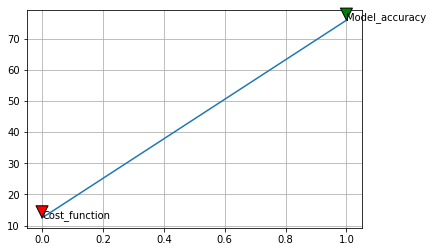

In [16]:
#Training model for different hyperparameters RawData, RawTarget, Weights, learning rate, epochs
print("raw_data:"+str(RawData.shape))
weights,cost=train(RawData,RawTarget,np.zeros((RawData.shape[1],1)),0.002,100)
Cost_function=cost_function(RawData,RawTarget,0)
predictedVal=predict(RawData,weights)
print("predictedVal :"+str(predictedVal.shape))
Model_accuracy=accuracy_model(predict(RawData,weights),RawTarget)
print("Cost_function :"+str(Cost_function))

#In order to plot the graph
plt.plot([Cost_function,Model_accuracy])
plt.annotate('Cost_function', (0,Cost_function), (0,Cost_function),
            arrowprops=dict(facecolor='red', shrink=0.05),
            )
plt.annotate('Model_accuracy', (1,Model_accuracy), (1,Model_accuracy),
            arrowprops=dict(facecolor='green', shrink=0.05),
            )
plt.grid()
plt.show()